### Cell 1: Imports & global settings

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os



### Cell 2: Test functions

In [50]:
def booth(x):
    x1, x2 = x
    return (x1 + 2*x2 - 7)**2 + (2*x1 + x2 - 5)**2

def rosenbrock(x):
    x1, x2 = x
    return (1 - x1)**2 + 5*(x2 - x1**2)**2

def pathological(x):
    x1, x2 = x
    return np.sin(5*x1) * np.cos(5*x2) + x1 ** 2 + x2 ** 2

TESTS = {"Booth": booth, "Rosenbrock": rosenbrock, "Pathological": pathological}

### Cell 3: Line search (bracket + golden section)

In [51]:
# def line_search(f, x, d, step=1e-2, tol=1e-6, grow=2.0, max_expand=60):
#     nrm = np.linalg.norm(d)
#     if nrm == 0:
#         return x, 0.0
#     d = d / nrm

#     phi = lambda a: f(x + a*d)
#     a, fa = 0.0, phi(0.0)
#     h = step
#     b, fb = a + h, phi(h)
#     if fb > fa:  # try opposite direction
#         h = -h
#         b, fb = a + h, phi(h)
#     k = 0
#     while fb < fa and k < max_expand:
#         a, fa = b, fb
#         h *= grow
#         b, fb = a + h, phi(b)
#         k += 1
#     left, right = min(a, b), max(a, b)

#     gr = (math.sqrt(5) - 1) / 2
#     c = right - gr*(right-left)
#     d1 = left + gr*(right-left)
#     fc, fd = phi(c), phi(d1)
#     while abs(right-left) > tol:
#         if fc < fd:
#             right, fd = d1, fc
#             d1 = c
#             c = right - gr*(right-left)
#             fc = phi(c)
#         else:
#             left, fc = c, fd
#             c = d1
#             d1 = left + gr*(right-left)
#             fd = phi(d1)
#     alpha = 0.5*(left + right)
#     return x + alpha*d, alpha

In [52]:
def line_search(f, x, d, a: float = -50, b: float = 50,
                          tol: float = 1e-6):
    golden_ratio = (np.sqrt(5) - 1) / 2  # 约等于0.618

    # 定义一维函数 phi(alpha) = f(x + alpha*d)
    def phi(alpha):
        return f(x + alpha * d)

    # 黄金分割搜索
    alpha1 = a + (1 - golden_ratio) * (b - a)
    alpha2 = a + golden_ratio * (b - a)

    f1 = phi(alpha1)
    f2 = phi(alpha2)

    while abs(b - a) > tol:
        if f1 < f2:
            b = alpha2
            alpha2 = alpha1
            f2 = f1
            alpha1 = a + (1 - golden_ratio) * (b - a)
            f1 = phi(alpha1)
        else:
            a = alpha1
            alpha1 = alpha2
            f1 = f2
            alpha2 = a + golden_ratio * (b - a)
            f2 = phi(alpha2)

    # 返回区间中点作为最优步长
    alpha_opt = (a + b) / 2
    return x + alpha_opt * d, alpha_opt

### Cell 4: CCD (basic + accel)

In [56]:
def ccd(f, x0, tol=1e-6, max_iter=10000):
    x = x0.copy()
    traj = [x.copy()]
    for iter in range(max_iter):
        x_prev = x.copy()
        for i in range(len(x)):
            e = np.zeros_like(x); e[i] = 1.0
            x, _ = line_search(f, x, e)
            traj.append(x.copy())
        if np.linalg.norm(x - x_prev) < tol:
            break
    return x, f(x), np.array(traj), iter+1

def ccd_accel(f, x0, tol=1e-4, max_iter=10000):
    x = x0.copy()
    traj = [x.copy()]
    for iter in range(max_iter):
        x_prev = x.copy()
        for i in range(len(x)):
            e = np.zeros_like(x); e[i] = 1.0
            x, _ = line_search(f, x, e)
            traj.append(x.copy())
        d_acc = x - x_prev
        x, _ = line_search(f, x, d_acc)
        traj.append(x.copy())
        if np.linalg.norm(x - x_prev) < tol:
            break
    return x, f(x), np.array(traj), iter+1


In [65]:
def plot_contours_and_trajectories(func, func_name,
                                   trajectory_basic, iters_basic,
                                   trajectory_accel, iters_accel,
                                   levels=50):
    # 选择绘制范围
    if func_name == "Booth":
        x_range = np.linspace(-3, 5, 300)
        y_range = np.linspace(-3, 5, 300)
    elif func_name == "Rosenbrock":
        x_range = np.linspace(-2, 2, 400)
        y_range = np.linspace(-1.5 , 1.5, 400)
    else:  # Pathological or others
        x_range = np.linspace(-3, 5, 300)
        y_range = np.linspace(-3, 5, 300)

    # 网格与函数值
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.array([func(np.array([xi, yi])) for xi, yi in zip(X.ravel(), Y.ravel())]).reshape(X.shape)

    # 画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ---------- 基础 CCD ----------
    contour1 = ax1.contour(X, Y, Z, levels=levels)
    ax1.plot(trajectory_basic[:, 0], trajectory_basic[:, 1], 'ro-', markersize=3, linewidth=1, alpha=0.7)
    ax1.plot(trajectory_basic[0, 0],  trajectory_basic[0, 1],  'go', markersize=8, label='Start')
    ax1.plot(trajectory_basic[-1, 0], trajectory_basic[-1, 1], 'bo', markersize=8, label='End')
    ax1.set_xlabel('x'); ax1.set_ylabel('y')
    ax1.set_title(f'Basic CCD - {func_name} (iters={iters_basic})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ---------- 加速 CCD ----------
    contour2 = ax2.contour(X, Y, Z, levels=levels)
    ax2.plot(trajectory_accel[:, 0], trajectory_accel[:, 1], 'ro-', markersize=3, linewidth=1, alpha=0.7)
    ax2.plot(trajectory_accel[0, 0],  trajectory_accel[0, 1],  'go', markersize=8, label='Start')
    ax2.plot(trajectory_accel[-1, 0], trajectory_accel[-1, 1], 'bo', markersize=8, label='End')
    ax2.set_xlabel('x'); ax2.set_ylabel('y')
    ax2.set_title(f'Accelerated CCD - {func_name} (iters={iters_accel})')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Cell 5: Experiments & plotting stubs 

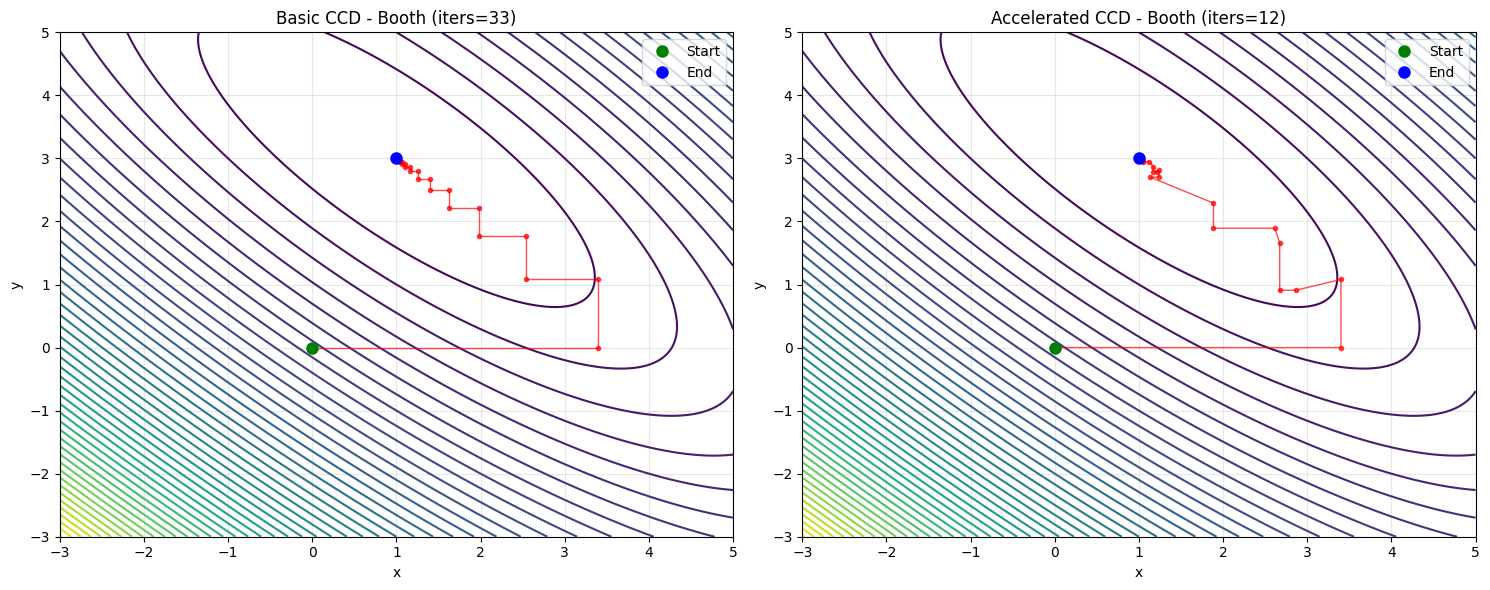

Booth start=[0. 0.]  CCD→[1.00000169 2.99999858], f=5.17e-12 iter=33
Booth start=[0. 0.]  CCD+Accel→[0.99996217 3.00003966], f=3.02e-09 iter=12


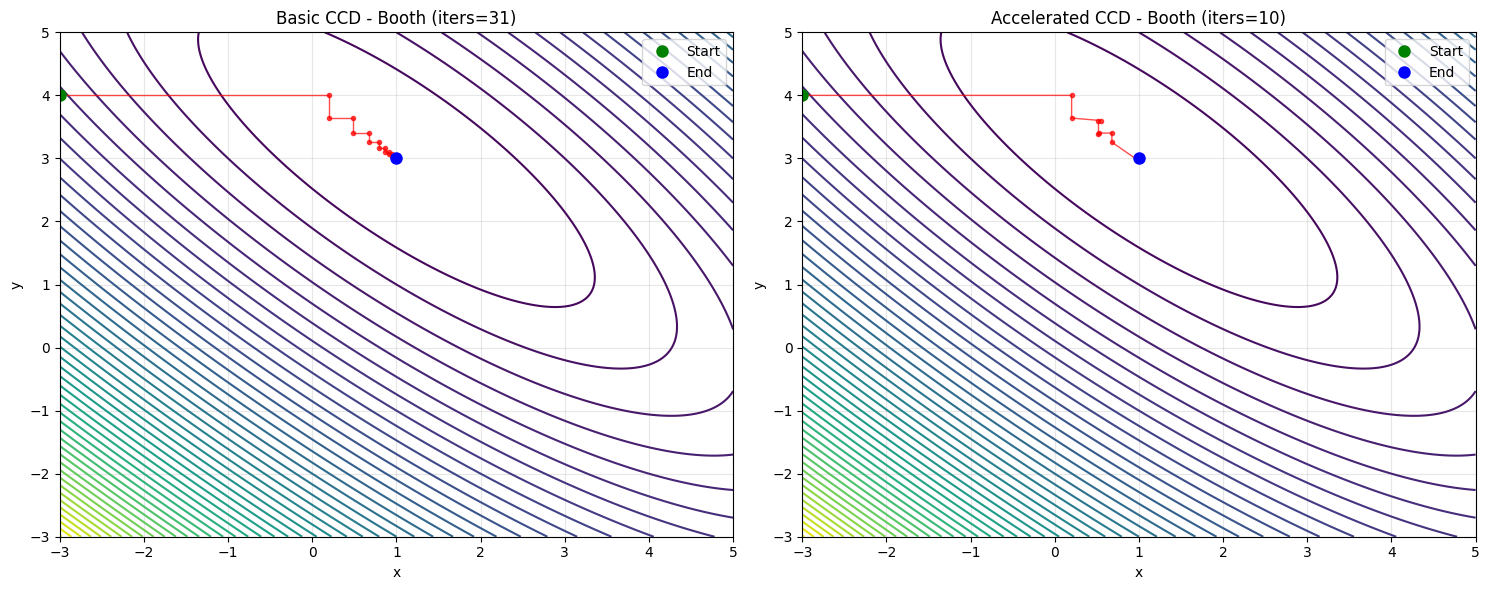

Booth start=[-3.  4.]  CCD→[0.99999886 3.00000103], f=2.43e-12 iter=31
Booth start=[-3.  4.]  CCD+Accel→[1.00020571 2.99981627], f=7.80e-08 iter=10


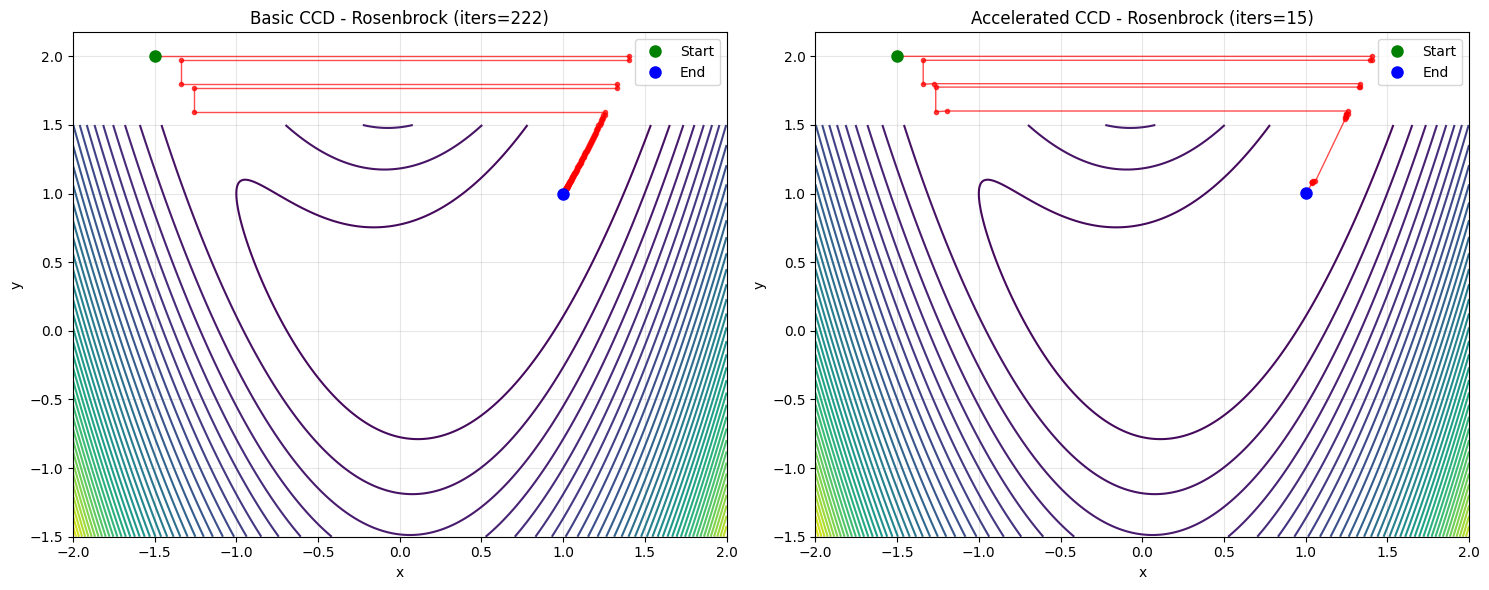

Rosenbrock start=[-1.5  2. ]  CCD→[1.00001056 1.00002122], f=1.12e-10 iter=222
Rosenbrock start=[-1.5  2. ]  CCD+Accel→[1.0006156  1.00123426], f=3.79e-07 iter=15


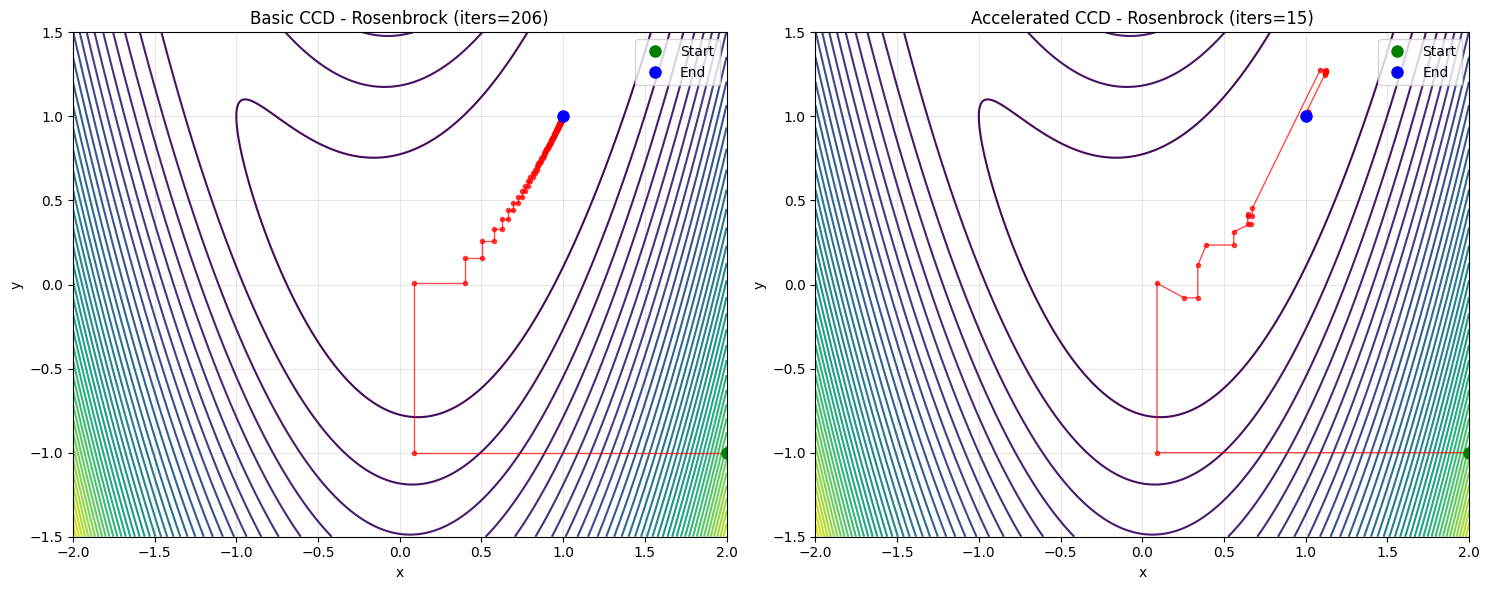

Rosenbrock start=[ 2. -1.]  CCD→[0.99998986 0.99997966], f=1.03e-10 iter=206
Rosenbrock start=[ 2. -1.]  CCD+Accel→[1.00027524 1.00057411], f=7.85e-08 iter=15


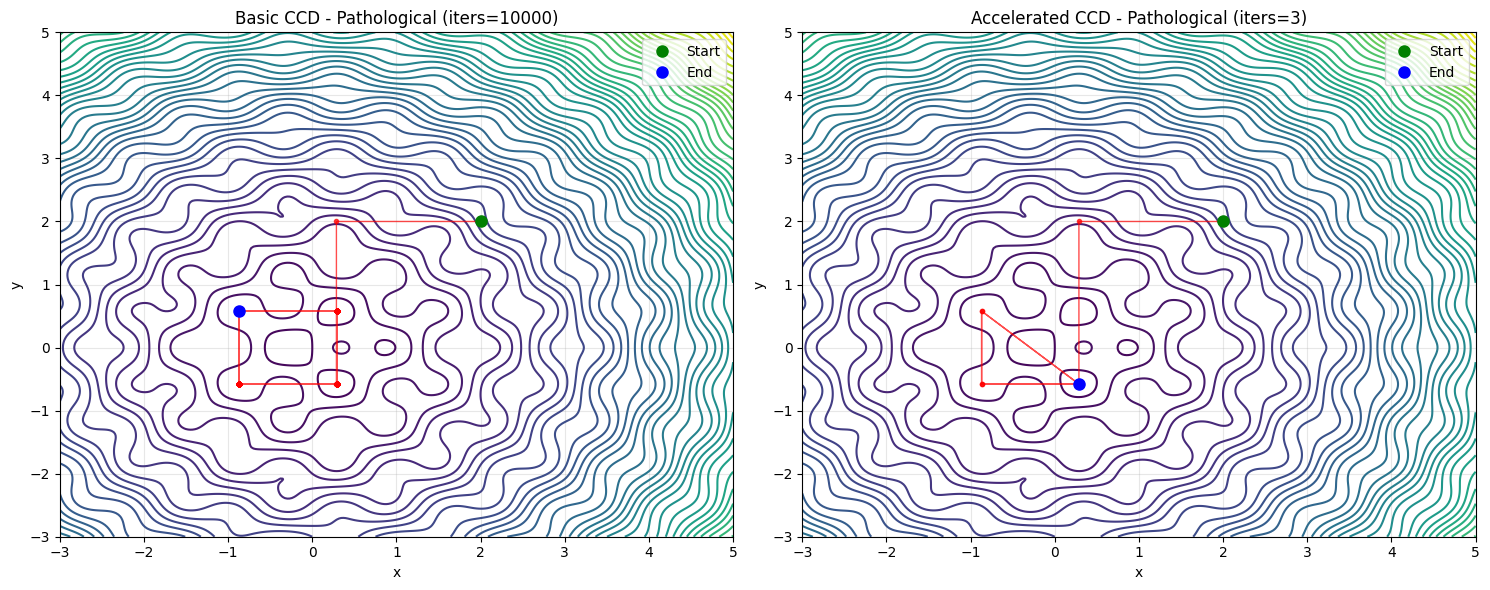

Pathological start=[2. 2.]  CCD→[-0.86932356  0.5782595 ], f=1.85e-01 iter=10000
Pathological start=[2. 2.]  CCD+Accel→[ 0.28982789 -0.58145288], f=-5.43e-01 iter=3


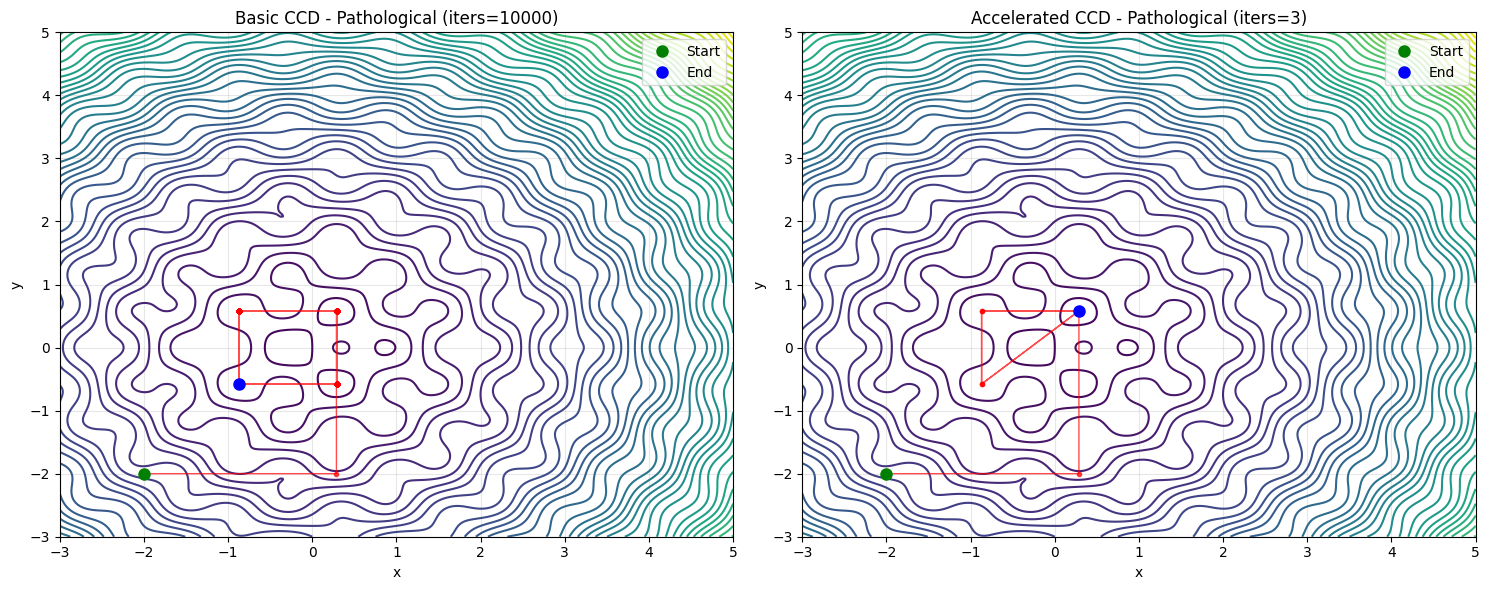

Pathological start=[-2. -2.]  CCD→[-0.86932389 -0.57825994], f=1.85e-01 iter=10000
Pathological start=[-2. -2.]  CCD+Accel→[0.28842374 0.58285201], f=-5.43e-01 iter=3


In [66]:
def run_experiment(f, name, starts):
    for idx, x0 in enumerate(starts):
        x1, fx1, traj1, iter_ccd = ccd(f, x0)
        x2, fx2, traj2, iter_ccd_accel = ccd_accel(f, x0)
        plot_contours_and_trajectories(f, name, traj1, iter_ccd, traj2, iter_ccd_accel)
        print(f"{name} start={x0}  CCD→{x1}, f={fx1:.2e} iter={iter_ccd}")
        print(f"{name} start={x0}  CCD+Accel→{x2}, f={fx2:.2e} iter={iter_ccd_accel}")

run_experiment(booth, "Booth", [np.array([0.,0.]), np.array([-3.,4.])])
run_experiment(rosenbrock, "Rosenbrock", [np.array([-1.5,2.]), np.array([2.,-1.])])
run_experiment(pathological, "Pathological", [np.array([2.,2.]), np.array([-2.,-2.])])
